In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import Optional, Callable, Tuple
from torch.nn import functional as F
import PIL
import os


device = "cuda"

@torch.inference_mode()
def spatial_gradient(data: torch.Tensor, dx: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
    # data: C, ...K spatial dims, return K, C, ... K spatial dims
    return torch.stack(torch.gradient(data, spacing=dx, dim=list(range(1, data.ndim))))


spatial_laplacian_conv_kernel = torch.tensor(
    [[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], 
    dtype=torch.float32, device=device,
).expand(3, 3, 3, 3)
# spatial_laplacian_conv_kernel = torch.tensor([[[[0.05, 0.2, 0.05], [0.2, -1, 0.2], [0.05, 0.2, 0.05]]]], dtype=torch.float32)
laplacian_conv = nn.Conv2d(3, 3, 3, padding="same", padding_mode="reflect", bias=False).eval().to(device)
laplacian_conv.weight = nn.Parameter(spatial_laplacian_conv_kernel)

@torch.inference_mode()
def spatial_laplacian(data: torch.Tensor) -> torch.Tensor:
    # data and output are C, H, W
    C, H, W = data.shape
    return laplacian_conv(input=data.view(1, C, H, W))


@torch.inference_mode()
def simulate(
    frames: torch.Tensor, 
    interaction_callable: Callable[[torch.Tensor], torch.Tensor],
    D: torch.Tensor,
    v: torch.Tensor,
    dt: float,
) -> torch.Tensor:
    # frames: T, C, H, W
    num_frames, num_components, height, width = frames.shape
    D = D.view(num_components, 1, 1)
    for t in range(num_frames - 1):
        interaction = interaction_callable(frames[t])
        # gradient = spatial_gradient(frames[t])  # (torch.einsum("i,i...->...", v, gradient)) + 
        laplacian = spatial_laplacian(frames[t])
        frames[t+1] = (frames[t] + (dt * ((D * laplacian) + interaction))).clip(0.0, 1.0)
    return frames


@torch.inference_mode()
def animate(frames: torch.Tensor, path: str, overwrite: bool = False, duration: int = 200, loop: int = 0) -> None:
    if (not overwrite) and (os.exists(path)):
        raise FileExistsError(f"{path=} already exists")

    from IPython.display import Image, display
    images = (frames.detach().cpu() * 255).byte()

    # Convert the tensor to a list of PIL Images
    image_list = [PIL.Image.fromarray(image.permute(1, 2, 0).numpy()) for image in images]

    # Save the list of PIL Images as a GIF
    os.makedirs(os.path.dirname(path), exist_ok=True)
    image_list[0].save(path, save_all=True, append_images=image_list[1:], duration=duration, loop=loop)
    display(Image(filename=path))

/home/haroun7/anaconda3/envs/efir/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _randn_initialization(_frames: torch.Tensor) -> None:
    _frames[0] = (0.5 + torch.randn(_frames.shape[1], _frames.shape[2], _frames.shape[3], dtype=torch.float32)).clip(0, 1.0)

def _ring_initialization(_frames: torch.Tensor, frequency_multiplier: float = 1.0) -> None:
    xs = torch.linspace(-0.5, 0.5, steps=_frames.shape[2])
    ys = torch.linspace(-0.5, 0.5, steps=_frames.shape[3])
    y, x = torch.meshgrid(xs, ys, indexing="xy")
    r = torch.sqrt(torch.pow(x, 2) + torch.pow(y, 2))
    _frames[0, 0] = torch.sin(2 * 3.14 * r * frequency_multiplier)
    _frames[0, 1] = torch.sin(4 * 3.14 * r * frequency_multiplier)
    _frames[0, 2] = torch.sin(8 * 3.14 * r * frequency_multiplier)

def _stripe_initialization(_frames: torch.Tensor, num_stripes: int = 12) -> None:
    _size = _frames.shape[2]
    stripe_width = _size // (num_stripes - 1)
    stripe_start = 0
    for stripe_idx, stripe_num in enumerate(range(num_stripes)):
        _frames[0, stripe_idx % 3, stripe_start: stripe_start + stripe_width, :] = 1.0
        stripe_start += stripe_width


def _two_kingdoms_initialization(_frames: torch.Tensor, blobsize: int = 12) -> None:
    _size = _frames.shape[2]
    _frames[0, 2] = 0.5
    _frames[0, 0, _size // 4 - blobsize: _size // 4 + blobsize, _size // 4 - blobsize: _size // 4 + blobsize] = 0.5
    _frames[0, 1, (3 * _size // 4) - blobsize: (3 *_size // 4) + blobsize, (3 *_size // 4) - blobsize: (3 *_size // 4) + blobsize] = 0.5


def _square_and_bg_initialization(_frames: torch.Tensor, influence: float = 0.2, radius: int = 10):
    _frames[0, 1] = 1.0 - influence
    _frames[0, 1] += influence * torch.rand(size=_frames[0, 0].shape, device=_frames.device)
    _frames[0, 0] += influence * torch.rand(size=_frames[0, 0].shape, device=_frames.device)
    
    h, w = _frames.shape[2], _frames.shape[3]
    ch, cw = h // 2, w // 2
    _frames[0, 1, ch - radius : ch + radius, cw - radius : cw + radius] = 0.5
    _frames[0, 0, ch - radius : ch + radius, cw - radius : cw + radius] = 0.25

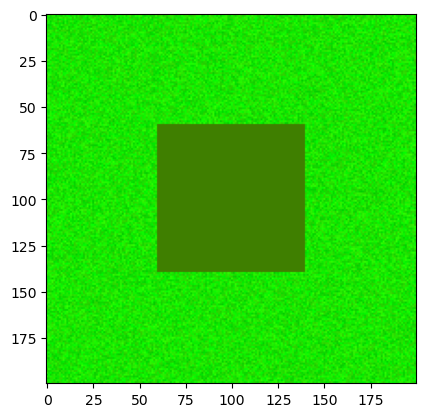

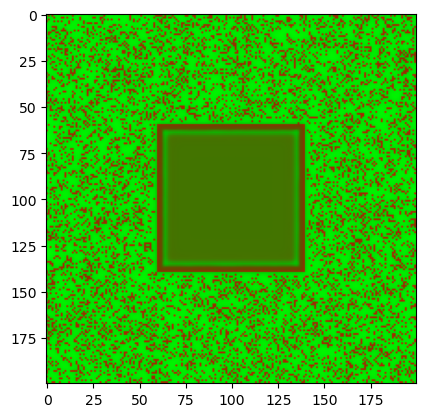

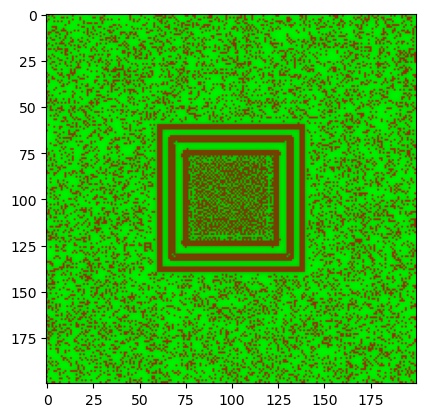

CPU times: user 4.29 s, sys: 1.16 s, total: 5.44 s
Wall time: 6.54 s


In [6]:
%%time
from functools import partial
num_frames = 10000
size = 200
num_channels = 3  # RGB


def roses_greens_and_bees(frame: torch.Tensor, grass_mortality_rate: float = 0.1, bee_murder_rate: float = 0.1, grass_pestilence_rate: float = 0.1, grass_growth_rate: float = 0.1, rose_fertility: float = 0.1, rose_mortality: float = -0.5, bee_mortality_rate: float = 0.1, bee_fertility: float = 0.1) -> torch.Tensor:
    interaction = torch.zeros_like(frame)
    # roses grow if there are greens and bees
    # roses die at a high rate
    interaction[0] = frame[1] * frame[2] * torch.pow(1 - frame[0], 0.5) * rose_fertility - rose_mortality
    
    # grass grows on its own
    interaction[1] = grass_growth_rate * frame[1] * (1 - frame[1]) - grass_mortality_rate - grass_pestilence_rate * frame[2]
    # bees grow if there are roses or grass
    interaction[2] = bee_fertility * frame[2] * (frame[1] + frame[0]) - bee_mortality_rate - bee_murder_rate * frame[2]
    return interaction

def rabbit_grass_reaction(frame: torch.Tensor, rabbit_birth_multiplier: float = 1.0, grass_creation_rate: float = 0.1, rabbit_death_rate: float = 0.1) -> torch.Tensor:
    # Really just gray scott model
    
    interaction = torch.zeros_like(frame)
    # rabbits pair up and procreate if theres enough grass
    procreation = frame[0] * frame[0] * frame[1]
    interaction[0] = rabbit_birth_multiplier * procreation - (grass_creation_rate + rabbit_death_rate) * frame[0]
    # grass grows on its own
    interaction[1] = -procreation + grass_creation_rate * (1 - frame[1])
    #  there is no third component
    interaction[2] = 0.0
    return interaction

frames = torch.zeros(num_frames, num_channels, size, size, dtype=torch.float32, device=device)
# _randn_initialization(frames)
# _ring_initialization(frames, frequency_multiplier=4.0)
_square_and_bg_initialization(frames, radius=40)
# frames[0, 1] = torch.randn(size, size, dtype=torch.float32, device=device)
# frames[0, 0, size // 4: 3 * size // 4, size // 4: 3 * size // 4] = 0.75
frames[:, 2] = 0.0

interaction_rgb = partial(
    roses_greens_and_bees, 
    rose_mortality=0.05, 
    rose_fertility=0.1, 
    grass_mortality_rate=0.01, 
    grass_growth_rate=0.6, 
    grass_pestilence_rate=0.1,
    bee_mortality_rate=0.01, 
    bee_fertility=0.3,
    bee_murder_rate=0.01,
)

interaction_rg = partial(
    rabbit_grass_reaction,
    grass_creation_rate=0.060,
    rabbit_death_rate=0.062,
    rabbit_birth_multiplier=1.0,
)

# _two_kingdoms_initialization(frames)
with torch.no_grad():
    frames = simulate(
        frames,
        interaction_rg,
        D=torch.tensor([0.08, 0.16, 0.0], device=device), # torch.tensor([0.001, 0.5, 0.1], device=device),
        v=torch.tensor([0.0, 0.0], device=device),
        dt=1.0,
    )

images = frames.detach().cpu()
plt.imshow(images[0].permute(1, 2, 0).numpy())
plt.show()
plt.imshow(images[100].permute(1, 2, 0).numpy())
plt.show()
plt.imshow(images[-1].permute(1, 2, 0).numpy())
plt.show()
# animate(frames, "../outputs/debug_rabits_and_grass.gif", overwrite=True, duration=5, loop=0)
# animate(frames[:, 1:2, ...].repeat(1, 3, 1, 1), "../outputs/debug_rabits_and_grass.gif", overwrite=True, duration=1, loop=0)